# 搭建基于CBHG的拼音到汉字语言模型

最近研究一下感觉用self-attention来对语言模型进行建模会更加不错，这里先做一个CBHG的tutorial吧

- 数据处理
- 模型搭建

## 1. 数据处理
- 读取数据

In [1]:
with open("data/zh.tsv", 'r', encoding='utf-8') as fout:
    data = fout.readlines()[:100]

In [2]:
from tqdm import tqdm

inputs = []
labels = []
for i in tqdm(range(len(data))):
    key, pny, hanzi = data[i].split('\t')
    inputs.append(pny.split(' '))
    labels.append(hanzi.strip('\n').split(' '))

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100150.53it/s]


In [3]:
print(inputs[:5])
print()
print(labels[:5])

[['lv4', 'shi4', 'yang2', 'chun1', 'yan1', 'jing3', 'da4', 'kuai4', 'wen2', 'zhang1', 'de', 'di3', 'se4', 'si4', 'yue4', 'de', 'lin2', 'luan2', 'geng4', 'shi4', 'lv4', 'de2', 'xian1', 'huo2', 'xiu4', 'mei4', 'shi1', 'yi4', 'ang4', 'ran2'], ['ta1', 'jin3', 'ping2', 'yao1', 'bu4', 'de', 'li4', 'liang4', 'zai4', 'yong3', 'dao4', 'shang4', 'xia4', 'fan1', 'teng2', 'yong3', 'dong4', 'she2', 'xing2', 'zhuang4', 'ru2', 'hai3', 'tun2', 'yi1', 'zhi2', 'yi3', 'yi1', 'tou2', 'de', 'you1', 'shi4', 'ling3', 'xian1'], ['pao4', 'yan3', 'da3', 'hao3', 'le', 'zha4', 'yao4', 'zen3', 'me', 'zhuang1', 'yue4', 'zheng4', 'cai2', 'yao3', 'le', 'yao3', 'ya2', 'shu1', 'de', 'tuo1', 'qu4', 'yi1', 'fu2', 'guang1', 'bang3', 'zi', 'chong1', 'jin4', 'le', 'shui3', 'cuan4', 'dong4'], ['ke3', 'shei2', 'zhi1', 'wen2', 'wan2', 'hou4', 'ta1', 'yi1', 'zhao4', 'jing4', 'zi', 'zhi3', 'jian4', 'zuo3', 'xia4', 'yan3', 'jian3', 'de', 'xian4', 'you4', 'cu1', 'you4', 'hei1', 'yu3', 'you4', 'ce4', 'ming2', 'xian3', 'bu4', 'dui4'

- 构造输入输出词典

In [4]:
def get_vocab(data):
    vocab = ['<PAD>']
    for line in tqdm(data):
        for char in line:
            if char not in vocab:
                vocab.append(char)
    return vocab

pny2id = get_vocab(inputs)
han2id = get_vocab(labels)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4774.61it/s]


In [5]:
print(pny2id[:10])
print(han2id[:10])

['<PAD>', 'lv4', 'shi4', 'yang2', 'chun1', 'yan1', 'jing3', 'da4', 'kuai4', 'wen2']
['<PAD>', '绿', '是', '阳', '春', '烟', '景', '大', '块', '文']


- data index

将字符symbol格式的文本数据通过字典转化为index形式的数字形式的表示。

In [6]:
input_num = [[pny2id.index(pny) for pny in line] for line in tqdm(inputs)]
label_num = [[han2id.index(han) for han in line] for line in tqdm(labels)]

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3931.01it/s]


- 数据生成器


In [7]:
import numpy as np
def get_batch(input_data, label_data, batch_size):
    batch_num = len(input_data) // batch_size
    for k in range(batch_num):
        begin = k * batch_size
        end = begin + batch_size
        input_batch = input_data[begin:end]
        label_batch = label_data[begin:end]
        max_len = max([len(line) for line in input_batch])
        input_batch = np.array([line + [0] * (max_len - len(line)) for line in input_batch])
        label_batch = np.array([line + [0] * (max_len - len(line)) for line in label_batch])
        yield input_batch, label_batch
        
        
batch = get_batch(input_num, label_num, 4)
input_batch, label_batch = next(batch)
print(input_batch)
print(label_batch)

[[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  11  16  17
   18   2   1  19  20  21  22  23  24  25  26  27   0   0   0]
 [ 28  29  30  31  32  11  33  34  35  36  37  38  39  40  41  36  42  43
   44  45  46  47  48  49  50  51  49  52  11  53   2  54  20]
 [ 55  56  57  58  59  60  61  62  63  64  15  65  66  67  59  67  68  69
   11  70  71  49  72  73  74  75  76  77  59  78  79  42   0]
 [ 80  81  82   9  83  84  28  49  85  86  75  87  88  89  39  56  90  11
   91  92  93  92  94  95  92  96  97  98  32  99 100   0   0]]
[[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  11  16  17
   18   2   1  19  20  21  22  23  24  25  26  27   0   0   0]
 [ 28  29  30  31  32  11  33  34  35  36  37  38  39  40  41  42  43  44
   45  46  47  48  49  50  51  52  50  53  11  54  55  56  57]
 [ 58  59  60  61  62  63  64  65  66  67  68  69  70  71  62  71  72  73
   74  75  76  77  78  79  80  81  82  83  62  84  85  86   0]
 [ 87  88  89  90  91  92  93  50  94  9

数据处理部分先到这里，有了词典和数据，就能将符号转化为数值形式的索引号了。

## 2. 模型搭建
- 模型结构如下：
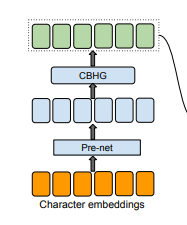

- 其中CBHG结构如下：
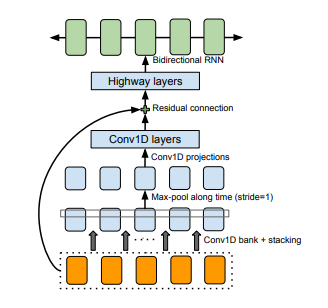

CBHG模块由1-D convolution bank ，highway network ，bidirectional GRU 组成。
它的功能是从输入中提取有价值的特征，有利于提高模型的泛化能力。这里直接借用原作者代码，给出简要介绍。

### embedding层
光有对应的id，没法很好的表征文本信息，这里就涉及到构造词向量，关于词向量不在说明，网上有很多资料，模型中使用词嵌入层，通过训练不断的学习到语料库中的每个字的词向量，代码如下：

In [8]:
import tensorflow as tf

In [9]:
def embed(inputs, vocab_size, num_units, zero_pad=True, scope="embedding", reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        lookup_table = tf.get_variable('lookup_table',
                                       dtype=tf.float32,
                                       shape=[vocab_size, num_units],
                                       initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01))
        if zero_pad:
            lookup_table = tf.concat((tf.zeros(shape=[1, num_units]),
                                      lookup_table[1:, :]), 0)
    return tf.nn.embedding_lookup(lookup_table, inputs)

### Encoder pre-net module
embeding layer之后是一个encoder pre-net模块，它有两个隐藏层，层与层之间的连接均是全连接；
第一层的隐藏单元数目与输入单元数目一致，
第二层的隐藏单元数目为第一层的一半；两个隐藏层采用的激活函数均为ReLu，并保持0.5的dropout来提高泛化能力 

In [10]:
def prenet(inputs, num_units=None, is_training=True, scope="prenet", reuse=None, dropout_rate=0.2):
    '''Prenet for Encoder and Decoder1.
    Args:
      inputs: A 2D or 3D tensor.
      num_units: A list of two integers. or None.
      is_training: A python boolean.
      scope: Optional scope for `variable_scope`.
      reuse: Boolean, whether to reuse the weights of a previous layer
        by the same name.

    Returns:
      A 3D tensor of shape [N, T, num_units/2].
    '''

    with tf.variable_scope(scope, reuse=reuse):
        outputs = tf.layers.dense(inputs, units=num_units[0], activation=tf.nn.relu, name="dense1")
        outputs = tf.layers.dropout(outputs, rate=dropout_rate, training=is_training, name="dropout1")
        outputs = tf.layers.dense(outputs, units=num_units[1], activation=tf.nn.relu, name="dense2")
        outputs = tf.layers.dropout(outputs, rate=dropout_rate, training=is_training, name="dropout2")
    return outputs  # (N, ..., num_units[1])

### conv bank
输入序列首先会经过一个卷积层，注意这个卷积层，它有K个大小不同的1维的filter，其中filter的大小为1,2,3…K。
这些大小不同的卷积核提取了长度不同的上下文信息。其实就是n-gram语言模型的思想，K的不同对应了不同的gram, 
例如unigrams, bigrams, up to K-grams，然后，将经过不同大小的k个卷积核的输出堆积在一起
（注意：在做卷积时，运用了padding，因此这k个卷积核输出的大小均是相同的），
也就是把不同的gram提取到的上下文信息组合在一起，下一层为最大池化层，stride为1，width为2。
- 定义一个卷积层

In [11]:
def conv1d(inputs,
       filters=None,
       size=1,
       rate=1,
       padding="SAME",
       use_bias=False,
       activation_fn=None,
       scope="conv1d",
       reuse=None):
    '''
    Args:
      inputs: A 3-D tensor with shape of [batch, time, depth].
      filters: An int. Number of outputs (=activation maps)
      size: An int. Filter size.
      rate: An int. Dilation rate.
      padding: Either `same` or `valid` or `causal` (case-insensitive).
      use_bias: A boolean.
      scope: Optional scope for `variable_scope`.
      reuse: Boolean, whether to reuse the weights of a previous layer
        by the same name.

    Returns:
      A masked tensor of the same shape and dtypes as `inputs`.
    '''    
    with tf.variable_scope(scope):
        if padding.lower() == "causal":
            # pre-padding for causality
            pad_len = (size - 1) * rate  # padding size
            inputs = tf.pad(inputs, [[0, 0], [pad_len, 0], [0, 0]])
            padding = "valid"

        if filters is None:
            filters = inputs.get_shape().as_list[-1]

        params = {"inputs": inputs, "filters": filters, "kernel_size": size,
                  "dilation_rate": rate, "padding": padding, "activation": activation_fn,
                  "use_bias": use_bias, "reuse": reuse}

        outputs = tf.layers.conv1d(**params)
    return outputs

- 由不同kernel size的卷积，组合而成的卷积块

参数为：

1. N: batch size
1. T: time steps
1. C: embedding hidden units

In [12]:
def conv1d_banks(inputs, num_units=None, K=16, is_training=True, scope="conv1d_banks", reuse=None):
    '''Applies a series of conv1d separately.

    Args:
      inputs: A 3d tensor with shape of [N, T, C]
      K: An int. The size of conv1d banks. That is,
        The `inputs` are convolved with K filters: 1, 2, ..., K.
      is_training: A boolean. This is passed to an argument of `batch_normalize`.

    Returns:
      A 3d tensor with shape of [N, T, K*Hp.embed_size//2].
    '''
    with tf.variable_scope(scope, reuse=reuse):
        outputs = conv1d(inputs, num_units // 2, 1)  # k=1
        for k in range(2, K + 1):  # k = 2...K
            with tf.variable_scope("num_{}".format(k)):
                output = conv1d(inputs, num_units, k)
                outputs = tf.concat((outputs, output), -1)
        outputs = normalize(outputs, is_training=is_training,
                            activation_fn=tf.nn.relu)
    return outputs  # (N, T, Hp.embed_size//2*K)

### gru
如果换成lstm有可能效果更好。

In [13]:
def gru(inputs, num_units=None, bidirection=False, seqlen=None, scope="gru", reuse=None):
    '''Applies a GRU.

    Args:
      inputs: A 3d tensor with shape of [N, T, C].
      num_units: An int. The number of hidden units.
      bidirection: A boolean. If True, bidirectional results
        are concatenated.
      scope: Optional scope for `variable_scope`.
      reuse: Boolean, whether to reuse the weights of a previous layer
        by the same name.

    Returns:
      If bidirection is True, a 3d tensor with shape of [N, T, 2*num_units],
        otherwise [N, T, num_units].
    '''
    with tf.variable_scope(scope, reuse=reuse):
        if num_units is None:
            num_units = inputs.get_shape().as_list[-1]

        cell = tf.contrib.rnn.GRUCell(num_units)
        if bidirection:
            cell_bw = tf.contrib.rnn.GRUCell(num_units)
            outputs, _ = tf.nn.bidirectional_dynamic_rnn(cell, cell_bw, inputs,
                                                         sequence_length=seqlen,
                                                         dtype=tf.float32)
            return tf.concat(outputs, 2)
        else:
            outputs, _ = tf.nn.dynamic_rnn(cell, inputs,
                                           sequence_length=seqlen,
                                           dtype=tf.float32)

    return outputs

### highwaynet
下一层输入到highway layers，highway nets的每一层结构为：把输入同时放入到两个一层的全连接网络中，
这两个网络的激活函数分别采用了ReLu和sigmoid函数，假定输入为input，ReLu的输出为output1，sigmoid的输出为output2，
那么highway layer的输出为output=output1∗output2+input∗（1−output2)。论文中使用了4层highway layer。
代码如下：

In [14]:
def highwaynet(inputs, num_units=None, scope="highwaynet", reuse=None):
    '''Highway networks, see https://arxiv.org/abs/1505.00387
    Args:
      inputs: A 3D tensor of shape [N, T, W].
      num_units: An int or `None`. Specifies the number of units in the highway layer
             or uses the input size if `None`.
      scope: Optional scope for `variable_scope`.
      reuse: Boolean, whether to reuse the weights of a previous layer
        by the same name.
    Returns:
      A 3D tensor of shape [N, T, W].
    '''
    if not num_units:
        num_units = inputs.get_shape()[-1]

    with tf.variable_scope(scope, reuse=reuse):
        H = tf.layers.dense(inputs, units=num_units, activation=tf.nn.relu, name="dense1")
        T = tf.layers.dense(inputs, units=num_units, activation=tf.nn.sigmoid,
                            bias_initializer=tf.constant_initializer(-1.0), name="dense2")
        C = 1. - T
        outputs = H * T + inputs * C


    return outputs

### batch normalize

使用bn层，加速训练。

In [15]:
def normalize(inputs,
              decay=.99,
              epsilon=1e-8,
              is_training=True,
              activation_fn=None,
              reuse=None,
              scope="normalize"):
    '''Applies {batch|layer} normalization.

    Args:
      inputs: A tensor with 2 or more dimensions, where the first dimension has
        `batch_size`. If type is `bn`, the normalization is over all but
        the last dimension. Or if type is `ln`, the normalization is over
        the last dimension. Note that this is different from the native
        `tf.contrib.layers.batch_norm`. For this I recommend you change
        a line in ``tensorflow/contrib/layers/python/layers/layer.py`
        as follows.
        Before: mean, variance = nn.moments(inputs, axis, keep_dims=True)
        After: mean, variance = nn.moments(inputs, [-1], keep_dims=True)
      type: A string. Either "bn" or "ln".
      decay: Decay for the moving average. Reasonable values for `decay` are close
        to 1.0, typically in the multiple-nines range: 0.999, 0.99, 0.9, etc.
        Lower `decay` value (recommend trying `decay`=0.9) if model experiences
        reasonably good training performance but poor validation and/or test
        performance.
      is_training: Whether or not the layer is in training mode. W
      activation_fn: Activation function.
      scope: Optional scope for `variable_scope`.

    Returns:
      A tensor with the same shape and data dtype as `inputs`.
    '''
    inputs_shape = inputs.get_shape()
    inputs_rank = inputs_shape.ndims

    # use fused batch norm if inputs_rank in [2, 3, 4] as it is much faster.
    # pay attention to the fact that fused_batch_norm requires shape to be rank 4 of NHWC.
    inputs = tf.expand_dims(inputs, axis=1)
    outputs = tf.contrib.layers.batch_norm(inputs=inputs,
                                            decay=decay,
                                            center=True,
                                            scale=True,
                                            updates_collections=None,
                                            is_training=is_training,
                                            scope=scope,
                                            zero_debias_moving_mean=True,
                                            fused=True,
                                            reuse=reuse)
    outputs = tf.squeeze(outputs, axis=1)

    if activation_fn:
        outputs = activation_fn(outputs)
    return outputs

### 搭建模型
由各个组件构成模型。
- 模型结构如下：
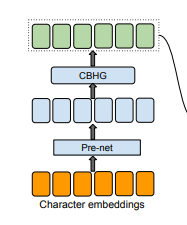

- 其中CBHG结构如下：
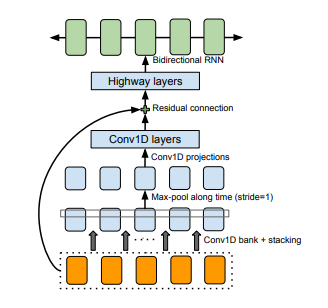

- 模型代码如下：

In [16]:
class Graph():
    '''Builds a model graph'''

    def __init__(self, arg):
        tf.reset_default_graph()
        self.pny_size = arg.pny_size
        self.han_size = arg.han_size
        self.embed_size = arg.embed_size
        self.is_training = arg.is_training
        self.num_highwaynet_blocks = arg.num_highwaynet_blocks
        self.encoder_num_banks = arg.encoder_num_banks
        self.lr = arg.lr
        
        self.x = tf.placeholder(tf.int32, shape=(None, None))
        self.y = tf.placeholder(tf.int32, shape=(None, None))
        
        # Character Embedding for x
        enc = embed(self.x, self.pny_size, self.embed_size, scope="emb_x")
        # Encoder pre-net
        prenet_out = prenet(enc,
                            num_units=[self.embed_size, self.embed_size // 2],
                            is_training=self.is_training)  # (N, T, E/2)

        # Encoder CBHG
        ## Conv1D bank
        enc = conv1d_banks(prenet_out,
                            K=self.encoder_num_banks,
                            num_units=self.embed_size // 2,
                            is_training=self.is_training)  # (N, T, K * E / 2)

        ## Max pooling
        enc = tf.layers.max_pooling1d(enc, 2, 1, padding="same")  # (N, T, K * E / 2)

        ## Conv1D projections
        enc = conv1d(enc, self.embed_size // 2, 5, scope="conv1d_1")  # (N, T, E/2)
        enc = normalize(enc, is_training=self.is_training,
                            activation_fn=tf.nn.relu, scope="norm1")
        enc = conv1d(enc, self.embed_size // 2, 5, scope="conv1d_2")  # (N, T, E/2)
        enc = normalize(enc, is_training=self.is_training,
                            activation_fn=None, scope="norm2")
        enc += prenet_out  # (N, T, E/2) # residual connections

        ## Highway Nets
        for i in range(self.num_highwaynet_blocks):
            enc = highwaynet(enc, num_units=self.embed_size // 2,
                                scope='highwaynet_{}'.format(i))  # (N, T, E/2)

        ## Bidirectional GRU
        enc = gru(enc, self.embed_size // 2, True, scope="gru1")  # (N, T, E)

        ## Readout
        self.outputs = tf.layers.dense(enc, self.han_size, use_bias=False)
        self.preds = tf.to_int32(tf.argmax(self.outputs, axis=-1))

        if self.is_training:
            self.loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y, logits=self.outputs)
            self.istarget = tf.to_float(tf.not_equal(self.y, tf.zeros_like(self.y)))  # masking
            self.hits = tf.to_float(tf.equal(self.preds, self.y)) * self.istarget
            self.acc = tf.reduce_sum(self.hits) / tf.reduce_sum(self.istarget)
            self.mean_loss = tf.reduce_sum(self.loss * self.istarget) / tf.reduce_sum(self.istarget)

            # Training Scheme
            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
            self.train_op = self.optimizer.minimize(self.mean_loss, global_step=self.global_step)

            # Summary
            tf.summary.scalar('mean_loss', self.mean_loss)
            tf.summary.scalar('acc', self.acc)
            self.merged = tf.summary.merge_all()


### 参数设定

In [17]:
def create_hparams():
    params = tf.contrib.training.HParams(
        
        # vocab
        pny_size = 50,
        han_size = 50,
        # embedding size
        embed_size = 300,
        num_highwaynet_blocks = 4,
        encoder_num_banks = 8,
        lr = 0.001,
        is_training = True)
    return params

arg = create_hparams()
arg.pny_size = len(pny2id)
arg.han_size = len(han2id)

### 模型训练

In [18]:
import os

epochs = 25
batch_size = 4

g = Graph(arg)

saver =tf.train.Saver()
with tf.Session() as sess:
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    if os.path.exists('logs/model.meta'):
        saver.restore(sess, 'logs/model')
    writer = tf.summary.FileWriter('tensorboard/lm', tf.get_default_graph())
    for k in range(epochs):
        total_loss = 0
        batch_num = len(input_num) // batch_size
        batch = get_batch(input_num, label_num, batch_size)
        for i in range(batch_num):
            input_batch, label_batch = next(batch)
            feed = {g.x: input_batch, g.y: label_batch}
            cost,_ = sess.run([g.mean_loss,g.train_op], feed_dict=feed)
            total_loss += cost
            if (k * batch_num + i) % 10 == 0:
                rs=sess.run(merged, feed_dict=feed)
                writer.add_summary(rs, k * batch_num + i)
        if (k+1) % 5 == 0:
            print('epochs', k+1, ': average loss = ', total_loss/batch_num)
    saver.save(sess, 'logs/model')
    writer.close()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
INFO:tensorflow:Restoring parameters from logs/model
epochs 5 : average loss =  1.2706838726997376
epochs 10 : average loss =  0.7730961179733277
epochs 15 : average loss =  0.4291091418266296
epochs 20 : average loss =  0.2579580122232437
epochs 25 : average loss =  0.17582486391067506


### 模型推断

In [19]:
arg.is_training = False

g = Graph(arg)

saver =tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, 'logs/model')
    while True:
        line = input('输入测试拼音: ')
        if line == 'exit': break
        line = line.strip('\n').split(' ')
        x = np.array([pny2id.index(pny) for pny in line])
        x = x.reshape(1, -1)
        preds = sess.run(g.preds, {g.x: x})
        got = ''.join(han2id[idx] for idx in preds[0])
        print(got)

INFO:tensorflow:Restoring parameters from logs/model
输入测试拼音: lv4 shi4 yang2 chun1 yan1 jing3 da4 kuai4 wen2 zhang1 de di3 se4 si4 yue4 de lin2 luan2 geng4 shi4 lv4 de2 xian1 huo2 xiu4 mei4 shi1 yi4 ang4 ran2
绿是阳春烟景大块文章的底色四月的林峦更是绿得鲜秀秀秀然回债权
输入测试拼音: exit
